# ANALYZING COVID-19 DATA

## 1. Data Wrangling

## 1.1 Introduction

In this section, we will gather covid data from the official CDC database and initiate data wrangling. Out ultimate goal is to see if there is correlation the number of covid cases/death with respect to intervention (lockdown, social distancing, mask wearing, etc...) or lack thereof.

In [149]:
# import relevant packages
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt 
import requests
import collections
import random
import math

In [150]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/02-26-2021.csv')
us_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/02-26-2021.csv')


In [151]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,55714,55733,55759,55770,55775,55827,55840,55847,55876,55876
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,107167,107931,108823,109674,110521,111301,112078,112897,113580,114209
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,113092,113255,113430,113593,113761,113948,114104,114234,114382,114543
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,10866,10889,10908,10948,10976,10998,11019,11042,11069,11089
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,20807,20854,20882,20923,20981,21026,21055,21086,21108,21114


In [152]:
confirmed_df.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21
269,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,2448,2448,2475,2482,2488,2494,2501,2512,2524,2526
270,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,183612,185336,187309,189326,191203,193029,194548,196812,198554,200382
271,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2285,2310,2342,2363,2375,2411,2444,2473,2545,2586
272,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,78534,79002,79557,80090,80687,81341,82011,82421,82655,82897
273,NaN,Zimbabwe,-19.015438,29.154857,0,0,0,0,0,0,...,36089,36115,36148,36179,36223,36248,36260,36271,36289,36321


In [153]:
confirmed_df_T = confirmed_df.T
confirmed_df_T1 = confirmed_df_T.iloc[4:]
total_confirmed = confirmed_df_T1.sum(axis=1).reset_index()
total_confirmed.rename(columns={'index':'date', 0: "conf_cases"}, inplace=True)
total_confirmed.head(20)

,date,conf_cases
0,1/22/20,557.0
1,1/23/20,655.0
2,1/24/20,941.0
3,1/25/20,1433.0
4,1/26/20,2118.0
5,1/27/20,2927.0
6,1/28/20,5578.0
7,1/29/20,6167.0
8,1/30/20,8235.0
9,1/31/20,9927.0


In [154]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,2443,2444,2446,2446,2446,2449,2449,2449,2451,2451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,1796,1816,1835,1856,1876,1897,1918,1939,1956,1969
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,2983,2987,2991,2996,3002,3007,3010,3013,3018,3022
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,110,110,110,112,112,112,112,112,112,112
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,508,508,510,510,511,511,512,514,515,516


In [155]:
us_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2021-02-27 05:30:48,32.3182,-86.9023,491849,9869,285130.0,196850.0,1.0,10031.214405,2281648.0,NaN,2.006510,84000001.0,USA,46533.997799,NaN
1,Alaska,US,2021-02-27 05:30:48,61.3707,-152.4044,58263,290,NaN,57973.0,2.0,7964.376764,1671043.0,NaN,0.497743,84000002.0,USA,228426.549290,NaN
2,American Samoa,US,2021-02-27 05:30:48,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN
3,Arizona,US,2021-02-27 05:30:48,33.7298,-111.4312,814528,15897,NaN,798631.0,4.0,11190.543608,3740067.0,NaN,1.951682,84000004.0,USA,51383.602357,NaN
4,Arkansas,US,2021-02-27 05:30:48,34.9697,-92.3731,318638,5407,308725.0,4506.0,5.0,10558.604866,2634339.0,NaN,1.696910,84000005.0,USA,87293.243696,NaN


## 1.2 Data Exploration

In [156]:
# see summary of the data
confirmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Columns: 417 entries, Province/State to 3/9/21
dtypes: float64(2), int64(413), object(2)
memory usage: 892.8+ KB


In [147]:
us_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        58 non-null     object 
 1   Country_Region        58 non-null     object 
 2   Last_Update           58 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             58 non-null     int64  
 6   Deaths                58 non-null     int64  
 7   Recovered             34 non-null     float64
 8   Active                58 non-null     float64
 9   FIPS                  58 non-null     float64
 10  Incident_Rate         56 non-null     float64
 11  Total_Test_Results    56 non-null     float64
 12  People_Hospitalized   0 non-null      float64
 13  Case_Fatality_Ratio   57 non-null     float64
 14  UID                   58 non-null     float64
 15  ISO3                  58 

In [157]:
confirmed_belgium = confirmed_df.loc[confirmed_df['Country/Region'] == 'Belgium']

In [158]:
confirmed_belgium_T = confirmed_belgium.T
confirmed_belgium.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21
23,NaN,Belgium,50.8333,4.469936,0,0,0,0,0,0,...,771511,772294,774344,777608,780251,783010,785809,787891,789008,791171


In [164]:
print(confirmed_belgium.index[0])

23


In [165]:
confirmed_belgium_data= confirmed_belgium_T.iloc[4:].reset_index()
confirmed_belgium_data.rename(columns={'index':'date', confirmed_belgium.index[0]: "conf_cases"}, inplace=True)
#confirmed_belgium_data.rename(columns={'index':'date', : "conf_cases"}, inplace=True)
confirmed_belgium_data.head(20)

,date,conf_cases
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0
5,1/27/20,0
6,1/28/20,0
7,1/29/20,0
8,1/30/20,0
9,1/31/20,0


In [166]:
list_data_belgium = confirmed_belgium_data['conf_cases'].tolist()

In [78]:
# function for Benford's law
#def benford_law(d):
#    n_dict = {}
 #   return math.log10(1 + 1/d)   

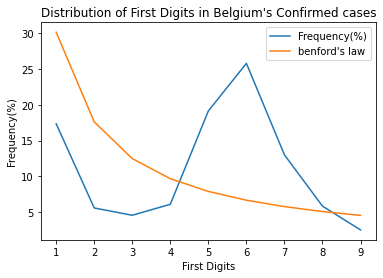

In [121]:

# This function takes any nonzero positive number and returns the first digit

def FirstDigit(number):
    while (number >= 10):
        number = number // 10
    return number

#This function takes a list (maybe array?) of positive numbers and returns a list (array?)
#of corresponding first digits
def ListFirstDigit(my_list):
  # in case the list contains zeros, drop them
    my_list = [i for i in my_list if i != 0]
    new_list = []
    for number in my_list:
        first_digit_num = FirstDigit(number)
        new_list.append(first_digit_num )
    return new_list

def CountNumberDigit(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    return collections.OrderedDict(sorted(freq.items()))
    #return freq

new_dict_belgium = CountNumberDigit(ListFirstDigit(list_data_belgium))

#type(new_dict)

df_belgium = pd.DataFrame(list(new_dict_belgium.items()),
                      columns=['First Digits','Frequency'])
df_belgium['Frequency(%)'] = df_belgium['Frequency']/df_belgium['Frequency'].sum() * 100
#df_belgium.plot(x='First Digits', y='Frequency(%)', title='Distribution of First Digits')
plt.plot(df_belgium['First Digits'], df_belgium['Frequency(%)'], label='Frequency(%)')
plt.plot(x_b, y_b, label="benford's law")
plt.ylabel('Frequency(%)')
plt.xlabel('First Digits')
plt.title("Distribution of First Digits in Belgium's Confirmed cases")
plt.legend()
plt.show()

In [58]:
df.head(10)

,First Digits,Frequency,Frequency(%)
0,1,68,17.346939
1,2,22,5.612245
2,3,18,4.591837
3,4,24,6.122449
4,5,75,19.132653
5,6,101,25.765306
6,7,51,13.010204
7,8,23,5.867347
8,9,10,2.551020


In [59]:
df['Frequency'].sum()

392

In [60]:
len(list_data_belgium)

405

In [62]:
print(list_data_belgium[0:14])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [98]:
list_data_total = total_confirmed['conf_cases'].tolist()
x_b = np.array([1,2,3,4,5,6,7,8,9])
y_b = np.log10(np.ones(9) + 1/x_b)*100
print(y_b)


[30.10299957 17.60912591 12.49387366  9.6910013   7.9181246   6.69467896
  5.7991947   5.11525224  4.57574906]


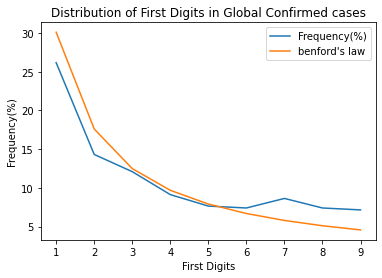

In [181]:
new_dict_total = CountNumberDigit(ListFirstDigit(list_data_total))

#type(new_dict)

df_total = pd.DataFrame(list(new_dict_total.items()),
                      columns=['First Digits','Frequency'])
df_total['Frequency(%)'] = df_total['Frequency']/df_total['Frequency'].sum() * 100
#df_total.plot(x='First Digits', y='Frequency(%)', title='Distribution of First Digits')
plt.plot(df_total['First Digits'], df_total['Frequency(%)'], label='Frequency(%)')
plt.plot(x_b, y_b, label="benford's law")
plt.ylabel('Frequency(%)')
plt.xlabel('First Digits')
plt.title('Distribution of First Digits in Global Confirmed cases')
plt.legend()
plt.show()

In [182]:
df_total.head()

,First Digits,Frequency,Frequency(%)
0,1.0,106,26.172840
1,2.0,58,14.320988
2,3.0,49,12.098765
3,4.0,37,9.135802
4,5.0,31,7.654321


In [167]:
def DistributionPlot(df, country):
    
    df_country = df.loc[df['Country/Region'] == country]
    df_country_T = df_country.T
    
    df_country_data= df_country_T.iloc[4:].reset_index()
    df_country_data.rename(columns={'index':'date', df_country.index[0]: "conf_cases"}, inplace=True)
    
    
    list_data_country = df_country_data['conf_cases'].tolist()
    
    
    new_dict_country = CountNumberDigit(ListFirstDigit(list_data_country))
    
    df_country_new = pd.DataFrame(list(new_dict_country.items()),
                      columns=['First Digits','Frequency'])
    df_country_new['Frequency(%)'] = df_country_new['Frequency']/df_country_new['Frequency'].sum() * 100
#df_belgium.plot(x='First Digits', y='Frequency(%)', title='Distribution of First Digits')
    plt.plot(df_country_new['First Digits'], df_country_new['Frequency(%)'], label='Frequency(%)')
    plt.plot(x_b, y_b, label="benford's law")
    plt.ylabel('Frequency(%)')
    plt.xlabel('First Digits')
    plt.title("Distribution of First Digits in %s Confirmed cases" % country)
    plt.legend()
    return plt.show()

In [119]:
confirmed_US = confirmed_df.loc[confirmed_df['Country/Region'] == 'US']
confirmed_US_T = confirmed_US.T
confirmed_US_data= confirmed_US_T.iloc[4:].reset_index()
confirmed_US_data.rename(columns={'index':'date', 249: "conf_cases"}, inplace=True)
confirmed_US_data.head(20)

,date,conf_cases
0,1/22/20,1
1,1/23/20,1
2,1/24/20,2
3,1/25/20,2
4,1/26/20,5
5,1/27/20,5
6,1/28/20,5
7,1/29/20,6
8,1/30/20,6
9,1/31/20,8


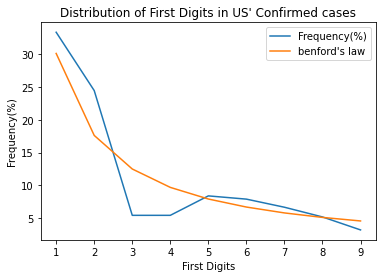

In [120]:
list_data_US = confirmed_US_data['conf_cases'].tolist()

new_dict_US = CountNumberDigit(ListFirstDigit(list_data_US))

#type(new_dict)

df_US = pd.DataFrame(list(new_dict_US.items()),
                      columns=['First Digits','Frequency'])
df_US['Frequency(%)'] = df_US['Frequency']/df_US['Frequency'].sum() * 100
#df_belgium.plot(x='First Digits', y='Frequency(%)', title='Distribution of First Digits')
plt.plot(df_US['First Digits'], df_US['Frequency(%)'], label='Frequency(%)')
plt.plot(x_b, y_b, label="benford's law")
plt.ylabel('Frequency(%)')
plt.xlabel('First Digits')
plt.title("Distribution of First Digits in US' Confirmed cases")
plt.legend()
plt.show()

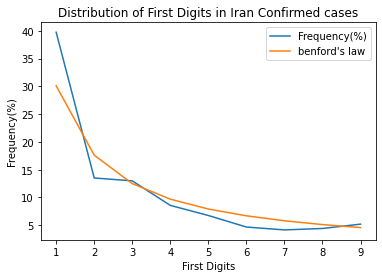

In [168]:
 DistributionPlot(confirmed_df, 'Iran')

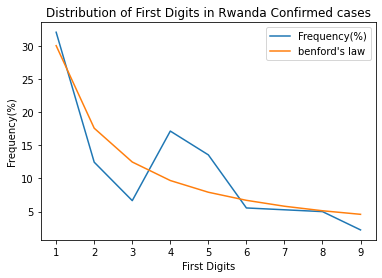

In [169]:
 DistributionPlot(confirmed_df, 'Rwanda')

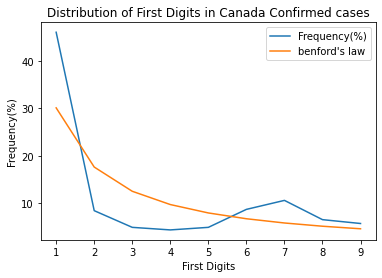

In [171]:
 DistributionPlot(confirmed_df, 'Canada')

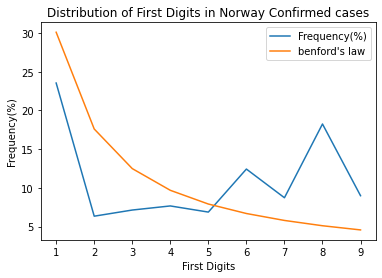

In [177]:
 DistributionPlot(confirmed_df, 'Norway')

# $\chi^2$ Test

In [178]:
def ChiSquareTest(Obs, Exp):
    chi_square = sum( (Obs - Exp) ** 2 / Exp for (Obs, Exp) in zip(Obs, Exp) )
    return print('The chi square value is', chi_square)

In [179]:
observed_v = df_total['Frequency(%)']
expected_v = y_b
ChiSquareTest(observed_v, expected_v)

The chi square value is 5.136797811061896
